# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Văn Lê Bá Thành
- MSSV: 22127390
- Lớp: 22CLC08

## Import các thư viện liên quan

In [430]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image

# remove
import sys

## Helper functions

In [431]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    # YOUR CODE HERE
    raw_image = Image.open(img_path).convert("RGB")
    return raw_image

def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    '''

    # YOUR CODE HERE
    plt.imshow(img_2d)

def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    Image.save(img_path, 'jpg')


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    # YOUR CODE HERE
    height, width = img_2d.size
    return np.reshape(img_2d, (width * height, 3)).astype(int)


def kmeans(img_1d, k_clusters= 5, max_iter= 10, init_centroids='in_pixels'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    
    # YOUR CODE HERE
    centroids = init_centroids_value(img_1d, k_clusters, init_centroids)
    height, width = img_1d.shape
    labels = np.zeros((height, width))

    while max_iter:
        
        # distance between each pixel and centroids
        distance = np.linalg.norm(img_1d - centroids[: , np.newaxis] , axis = 2)
        # Find the label of each pixel
        labels = np.argmin(distance, axis = 0)
        # Update centroids
        means = []
        for j in range(k_clusters):
            means.append(img_1d[labels == j].mean(axis = 0))
        means = np.array(means)
        for i in range(k_clusters):
          if len(means[i]) != 0:
            centroids[i] = means[i]
        
        max_iter -= 1
    return centroids, labels

    
def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''
    # YOUR CODE HERE
    result = np.full((img_2d_shape[0] * img_2d_shape[1], img_2d_shape[2]), 0)
    height, width = img_2d_shape[0], img_2d_shape[1]
    # pic = np.full((height, width, 3), 0)
    # print(pic)
    # for i in range(height*width):
    #     result[i] = centroids[labels[i]]

    # result = result.reshape(height, width, 3)
    result = centroids[labels].reshape(height, width, 3)
    print(result)
    return result


# Your additional functions here
def init_centroids_value(img_1d, k_clusters, init_centroids):

    # Create array with unique value
    new = np.copy([list(i) for i in img_1d])
    new = np.unique(new, axis=0)
    
    # Retrieve length (height * width) and dim of new array
    length, dim = new.shape
    if init_centroids == 'random':
        centroids = np.random.choice(256, size = (k_clusters, dim), replace=False)
    elif init_centroids == 'in_pixels':
        centroids = img_1d[np.random.choice(length, size = k_clusters, replace=False)]
    
    return centroids



## Your tests

Fitting model on a small sub-sample of the data
done in 0.861s.
Predicting color indices on the full image (k-means)
done in 0.173s.
Predicting color indices on the full image (random)
done in 0.403s.


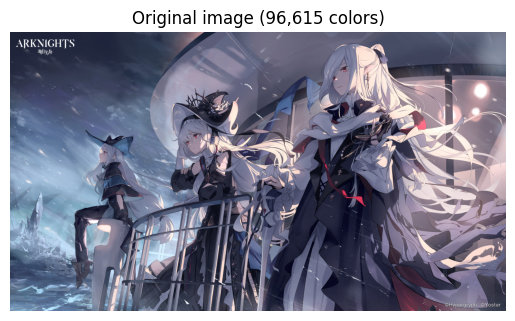

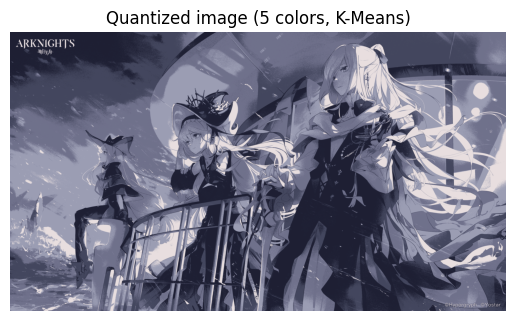

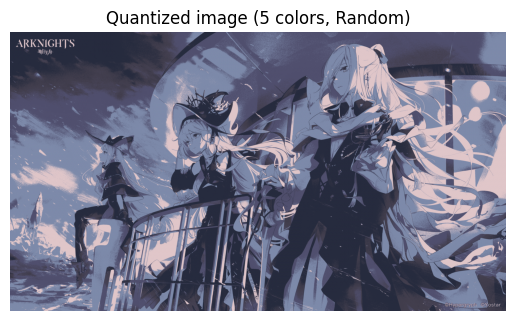

In [436]:
# YOUR CODE HERE
from time import time

import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

n_colors = 5

# Load the Summer Palace photo
china = Image.open("test.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")


codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

## Main FUNCTION

In [433]:
# YOUR CODE HERE
def main():
    img_path = input('Enter image\'s path: ')
    #max_iter = int(input("Enter max iteration: "))
    #k_cluster = int(input("Number of k cluster: "))
    #centroidsT = int(input("Initial centroid: \n0) random \n1) in_pixels \nYour choice: "))

    # File name add-on
    # if centroidsT == 0:
    #     centroids_type = 'random'
    # elif centroidsT == 1:
    #     centroids_type = 'in_pixels'
    # else:
    #     print('Invalid centroid initialization method')
    #     return
    
    raw_img = read_img(img_path)
    show_img(raw_img)
    pix = np.array(raw_img)
    raw_img_shape = pix.shape
    flatten = convert_img_to_1d(raw_img)
    # np.set_printoptions(threshold=sys.maxsize)
    # print(flatten)
    centroids, labels = kmeans(flatten)
    output = generate_2d_img(raw_img_shape, centroids, labels)
    #data = Image.fromarray(output, mode='RGB')
    show_img(output)
    

[[[ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  16  61]
  [ 23  

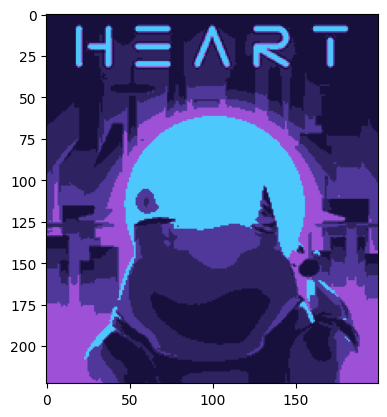

In [434]:
# Call main function
main()